In [32]:
###Imports
from numpy import *
from numpy.random import *
import numpy as np
import numpy.linalg as npl
import Bio.PDB as PDB

# Kronecker product, needed to calculate Matrix Normal pdf
from theano.tensor.slinalg import kron as kron_product


In [33]:
### Defining helper functions

def sph_rand(n=3):
    """
    Return a random vector on the n-dimensional sphere S.
    """
    # Simply generate n gaussian numbers and normalize
    # From Knuth's book
    a=zeros(n, 'd')
    for i in range(0,n):
        a[i]=normal(0,1)
    return a/sqrt(sum(a*a))


def random_rotation():
    """
    Generate a random 3D rotation matrix.
    
    Requires the function sph_rand
    
    Adapted from L. Devroye, Non-Uniform Random Variate Generation (page 607,
    available online at U{http://www-cgrl.cs.mcgill.ca/~luc/rnbookindex.html}),
    by setting s=1 to avoid generating roto-inversions.
    """

    # Random rotation around z
    x,y=sph_rand(2)
    rz=array(((x,-y,0), (y, x, 0), (0,0,1)), 'd')
    
    # Random rotation around y
    x,y=sph_rand(2)
    ry=array(((x,0,y), (0,1,0), (-y, 0, x)), 'd')
    
    # Random rotation around x
    x,y=sph_rand(2)
    rx=array(((1,0,0), (0,x,y), (0, -y, x)), 'd')
    
    # Combine the three and return
    rnd_rot = rz @ ry @ rx
    return rnd_rot


def to_origin(M):
    """
    Accepts a matrix and moves it to the origin
    """
    #sum the vectors (rows)
    sum_vectors = sum(M,0)
    
    #compute the center of mass, sum of vectors divided by number of vectors
    com = sum_vectors/M.shape[0]

    #move onto origin
    M_at_o = M-com
    
    return M_at_o


def is_orthogonal(RM):
    """
    Returns boolean T/F if matrix is orthogonal or not (M.t = M^-1 in orthogonal matricies)
    """
    #transpose
    a = RM.T

    #inverse
    b = npl.inv(RM)
    
    #Checks the differnce element wise is < 0.01
    #boolean, does transpose ~= inverse (a=b element wise?)
    c = np.allclose(a,b, atol=0.01)
    print("and orthogonality is...")
    print(c)
    return

In [34]:
### Biopython 

#REQUIRES PROTEIN FILE IN SAME LOCAL DIRECTORY AS THIS SCRIPT

##parsing structure
parser = PDB.PDBParser(QUIET=True)
structure = parser.get_structure("1IRH", "1irh.pdb")

##taking models of interest
first_model = structure[0]
second_model = structure[1]

##retriving C-alpha atoms
model_1_CA_chain = [] #empty lists to accept the biopython residue object, these go to the RMSD model
model_2_CA_chain = []

#retriving C-alpha coordinates
model_1_CA_coordlist = [] #empty lists to accept co-ordinates for each model, these go to the theano model
model_2_CA_coordlist = [] 

for chain in first_model:
    for residue in chain:
            try:
                model_1_CA_chain.append(residue['CA'])
                model_1_CA_coordlist.append(residue['CA'].get_coord()) #creates a list of lists containing all residue atom coordinates4
            except:
                pass

for chain in second_model:
    for residue in chain:
            try:
                model_2_CA_chain.append(residue['CA'])
                model_2_CA_coordlist.append(residue['CA'].get_coord()) #creates a list of lists containing all residue atom coordinates4
            except:
                pass
                
#Vertical stack to concatenate list of lists of coordinates into np array -
model_1_CA_coordarray = np.vstack(model_1_CA_coordlist)
# print(model_1_CA_coordarray)

model_2_CA_coordarray = np.vstack(model_2_CA_coordlist)
# print(model_2_CA_coordarray)

In [35]:
###RMSD
sup = PDB.Superimposer()

sup.set_atoms(model_1_CA_chain, model_2_CA_chain) #sets model 1 as fixed and model 2 as moving 
sup.apply(model_2_CA_chain) #rotates model 2 to be superimposed over model 1 with the lowest RSMD possible

model_2_superimpose =[] #empty list to accept extracted co-ordinates.

for atom in model_2_CA_chain:
    try:
        model_2_superimpose.append(atom.get_coord()) #creates a list of lists containing all residue atom coordinates so it an be compared wiht the MAP later
    except:
        pass

model_2_superimpose_array = np.vstack(model_2_superimpose)  # ready for comparison with the MAP estimate, later.
    

In [36]:
#Finding N (the number of rows (atoms))
# should add exception if models are different lengths
N = len(model_2_CA_coordarray)
print(N)

#  # or setting N and truncating the arrays 
# N = 10
# model_1_CA_coordarray = model_1_CA_coordarray[0:N,:]
# model_2_CA_coordarray = model_2_CA_coordarray[0:N,:]
# model_2_superimpose_array = model_2_superimpose_array[0:N,:]

## moving the two structures to the origin
input_struct1 = to_origin(model_1_CA_coordarray)
input_struct2 = to_origin(model_2_CA_coordarray)

##moving RMSD solution to origin
model_2_superimpose_to_o = to_origin(model_2_superimpose_array)

## Flatten matricies, for easier calcualtions later
input_struct1_f=array(input_struct1.flat)
input_struct2_f=array(input_struct2.flat)

61


In [37]:
###Theano model definition

# Imports for theano - THESE MUST BE SEPARATE from above.
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
import pymc3
from pymc3 import *
from pymc3.math import *
import theano.tensor as TT
import theano as T
from theano import function
from theano import pp
# Kronecker product, needed to calculate Matrix Normal pdf
from theano.tensor.slinalg import kron as kron_product

# Here we define the Theano model we will call later.
with Model() as model:
    
    ### Defining functions for the  model
         
    def make_rotation(i):
        """
        Determines quaternions from a unifrom prior and forms from them; a rotation matrix.
        Prior over the rotation is included within
        """
        ### Rotation prior
        #uniform prior used so as to not draw prefernce to one particualr parameter
        #this is the continuous , uniform, log-liklihood
        
        # the first argument states that i will be the name of the rotation made
        xr = Uniform('x'+str(i), 0, 1, testval=0.5, shape=3) # Note shape is 3-Dimensional
        
        #Background for this is in the paper provided
        theta1 = 2*np.pi*xr[1]
        theta2 = 2*np.pi*xr[2]
        
        r1 = TT.sqrt(1-xr[0])
        r2 = TT.sqrt(xr[0])

        # Difficult to check the quaternion length is 1 (unit quaternion) - difficult
        qx = TT.cos(theta2)*r2
        qy = TT.sin(theta1)*r1
        qz = TT.cos(theta1)*r1
        qw = TT.sin(theta2)*r2        
    
        ###The rotation matrix from the quaternions
        
        # initializes a matrix (here 3x3) with 1's on the diagonal
        R = T.shared(np.eye(3))
    
        #filling the rotation matrix
        # https://www.flipcode.com/documents/matrfaq.html#Q54
        #this is correct as per the link, but ?authenticity?
        # Row one
        R = TT.set_subtensor(R[0,0], 1-(2*TT.sqr(qy))-(2*TT.sqr(qz))) 
        R = TT.set_subtensor(R[0,1], (2*(qx*qy))-(2*(qz*qw))) 
        R = TT.set_subtensor(R[0,2], (2*(qx*qz))+(2*(qy*qw))) 
        # Row two
        R = TT.set_subtensor(R[1,0], (2*(qx*qy))+(2*(qz*qw))) 
        R = TT.set_subtensor(R[1,1], 1-(2*TT.sqr(qx))-(2*TT.sqr(qz))) 
        R = TT.set_subtensor(R[1,2], (2*(qy*qz))-(2*(qx*qw))) 
        # Row three
        R = TT.set_subtensor(R[2,0], (2*(qx*qz))-(2*(qy*qw))) 
        R = TT.set_subtensor(R[2,1], (2*(qy*qz))+(2*(qx*qw))) 
        R = TT.set_subtensor(R[2,2], 1-(2*TT.sqr(qx))-(2*TT.sqr(qy))) 
        return R
    
    ### GAUSSIAN WALK for Mu
    # Proposal for a prior over Ca trace space
    mu_u=Uniform('mu_u', 0, 1, shape=N)
    mu_v=Uniform('mu_v', 0, 1, shape=N)
    
    theta_mu = 2*np.pi*mu_v
    
    phi_mu = tt.arccos(1-2*mu_u)
    
    mu_x = tt.sin(phi_mu) * tt.cos(theta_mu)
    mu_y = tt.sin(phi_mu) * tt.sin(theta_mu)
    mu_z = tt.cos(phi_mu);
    
    mu_stack = tt.stack([mu_x, mu_y, mu_z], 1)

    # Turn unit vectors into vectors of length 3.8 (standard Ca-Ca stick)
    mu_ca_stack = 3.8*mu_stack

    # Cumulative sum of unit vectors along rows 
    # (ie. we get a Ca trace)
    mu_cumsum = tt.extra_ops.cumsum(mu_ca_stack, axis=0)

    # Move center of mass to (0,0,0)
    mean_structure = mu_cumsum-tt.mean(mu_cumsum, axis=0)
    
    #print initial output?
#     mean_structure_print = tt.printing.Print('mean_structure')(mean_structure)

    
    ### NOISE NEGATION
    
    # makes triangular covariance matrix, of dimension N.
    packed_L = LKJCholeskyCov('packed_L1', n=N, eta=2., sd_dist=HalfCauchy.dist(0.05)) #0.05 for each seems the sweet spot for N = 10
    # as a more orthodox alternate, one could use  Wishart Priors?

#     print initial values?
#     packed_L_print = tt.printing.Print('packed_L')(packed_L)
    
    # Convert a packed triangular matrix into a two dimensional array.
    L = expand_packed_triangular(N, packed_L)
    
    U = L.dot(L.T)

    sv=HalfNormal("sv1", sd=1)
    V=sv*TT.eye(3)
    
    # See https://en.wikipedia.org/wiki/Matrix_normal_distribution#Definition
    #this is the covariance matrix between the two structures
    VU=kron_product(V,U) #should these be multiplied by V'? 
        
    ####ROTATION
    r2 = Deterministic('r2',make_rotation("rTwo"))
    
    ### TRANSLATIONS
    translation_on_1 = Normal('trans1', mu=0, sd=1, shape=(3))
    translation_on_2 = Normal('trans2', mu=0, sd=1, shape=(3))
    
    trans1_print = tt.printing.Print('trans1')(translation_on_1)
    trans2_print = tt.printing.Print('trans2')(translation_on_2)

    #### FORMING THE STRUCTURES
    #predicted mean observed structure for the two structures to be superpositioned??
    observed_struct1 = mean_structure + translation_on_1
                           
    observed_struct2_initial = TT.dot(mean_structure, r2)
    observed_struct2 = observed_struct2_initial + translation_on_2

    ###Flattening for computation
    observed_struct1_f = TT.flatten(observed_struct1) 
    observed_struct2_f = TT.flatten(observed_struct2)    
    
    ### MAP of rotation, translation and Mu
    ## this is the liklihood
    x_obs = MvNormal("x_obs", mu=observed_struct1_f, cov=VU, observed=input_struct1_f)
    y_obs = MvNormal("y_obs", mu=observed_struct2_f, cov=VU, observed=input_struct2_f)
    
    ### Setting some of the final values to be in the trace and thus printable
    Mu = Deterministic('gMu', mean_structure)

trans1 __str__ = [ 0.  0.  0.]
trans2 __str__ = [ 0.  0.  0.]


In [38]:
### Calling Theano the model & processing outputs
map_estimate = find_MAP(maxeval=10000, model=model) # ML estimarion (liklihood x prior ) mind max

#print("THIS IS THE MAP ESTIMATE")
# print(map_estimate)

logp = 2,211.3, ||grad|| = 4,726.6: 10001it [00:51, 176.31it/s]                             



In [39]:
### Assigning variables from the MAP estimate

estimated_Mu = map_estimate['gMu']

t1 = map_estimate['trans1']
t2 = map_estimate['trans2']

r2 = map_estimate['r2'] 

r2_d = npl.det(r2) 

In [40]:
###Comparisons
# print('\n',"Comparing translations") #Omitted as we don't know true tranlsational difference
#first translation on input
# print('Real t1')
# print(trans1)
# MAP of first translation
print("Estimated t1")
print(t1)
#Second translation on input
# print("Real t2")
# print(trans2)
# MAP of second translation
print("estimated t2")
print(t2)

##Rotation Estimation
print('\n',"Comparing rotations")

#the rotation & trnaslationpeformed ny the RMSD method
print("RMSD rotation & translation used on model 2")
print(sup.rotran)

# the MAP of the rotation
print("Estimated r2")
print(r2)
print("The determinant is...")
print(r2_d)
is_orthogonal(r2)

###Guess at true structure
print("estimation of mean structure")
print(estimated_Mu)


Estimated t1
[ 0.76016928 -0.6549838   0.15062318]
estimated t2
[ 0.97863676 -0.43571592 -0.60572701]

 Comparing rotations
RMSD rotation & translation used on model 2
(array([[ 0.9980007 ,  0.03593814,  0.05199087],
       [-0.036528  ,  0.9992781 ,  0.01043988],
       [-0.05157815, -0.01231813,  0.99859299]]), array([-0.31738034, -1.68130816, -2.4038616 ]))
Estimated r2
[[ 0.97162303 -0.1128558  -0.20787557]
 [ 0.05418834  0.96166759 -0.26881049]
 [ 0.23024402  0.24991803  0.94049384]]
The determinant is...
1.0
and orthogonality is...
True
estimation of mean structure
[[ 25.02304988   4.98881788   7.79580612]
 [ 21.23728471   5.31738615   7.79080612]
 [ 17.48120247   5.89231592   7.75472355]
 [ 13.74498675   6.57521372   7.63496255]
 [ 10.11750832   7.68204271   7.39762344]
 [  6.37337003   8.16872007   6.9680032 ]
 [  2.99716046   6.56065491   6.29321774]
 [ -0.60592974   5.92633373   5.26590201]
 [ -0.22274689   2.33397366   4.08771696]
 [  1.50298411  -0.82007292   2.85733379]
 [

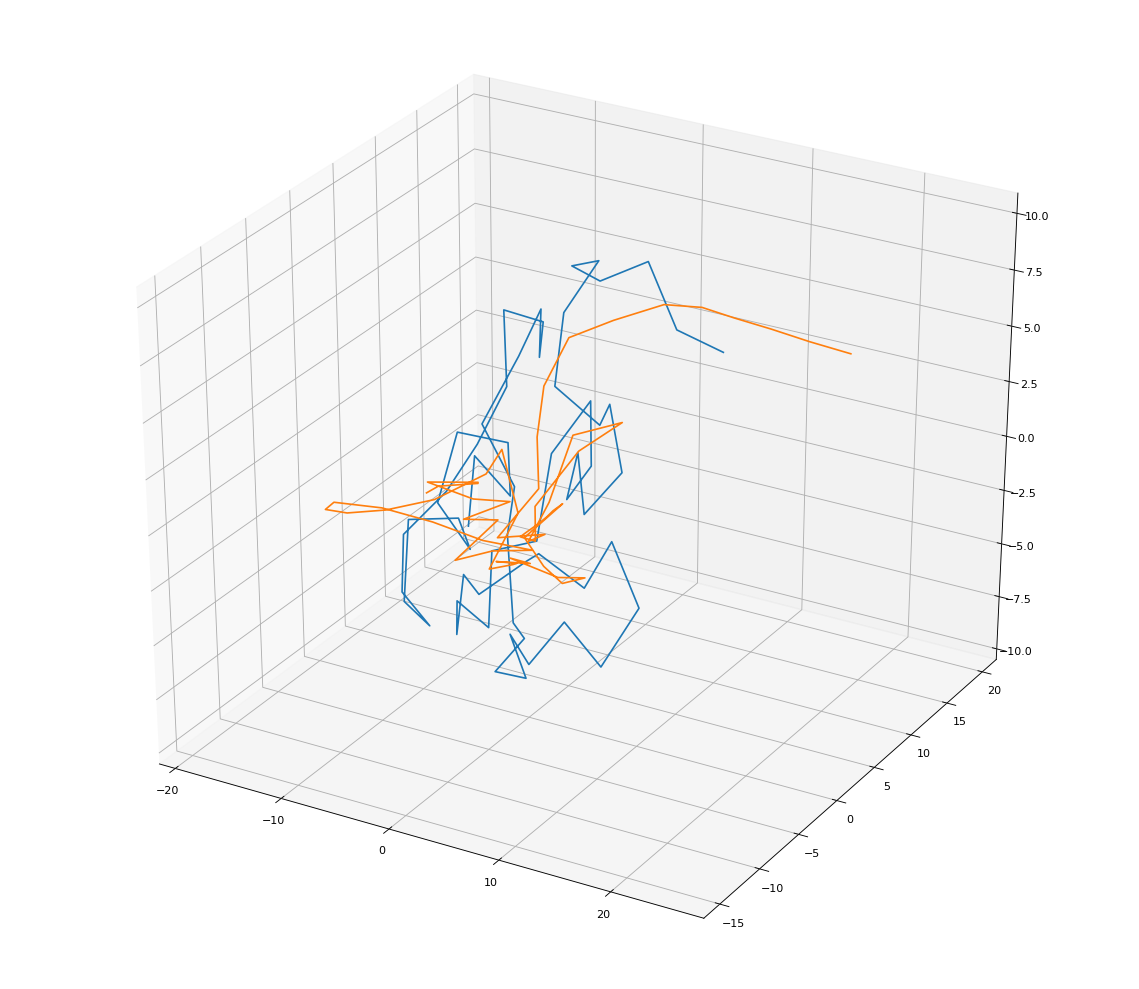

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(18, 16), dpi= 80)
ax = fig.add_subplot(111, projection='3d')
x=model_2_superimpose_to_o[:,0]
y=model_2_superimpose_to_o[:,1]
z=model_2_superimpose_to_o[:,2]
plt.plot(x, y, z)

x2=estimated_Mu[:,0]
y2=estimated_Mu[:,1]
z2=estimated_Mu[:,2]
plt.plot(x2, y2, z2)
plt.show()